# Market Maker Project: EDA and Model Evaluation

## Introduction
This notebook performs Exploratory Data Analysis (EDA) on the tick data used in the Market Maker Simulation & Algorithmic Trading Backtesting Platform. The dataset contains historical tick data for five instruments (AAPL, AMZN, GOOG, META, MSFT) with columns for timestamp, instrument, bid price, ask price, and volume. We will:
- Explore the dataset's characteristics (e.g., trends, seasonality, volatility).
- Fit ARIMA and LSTM models to forecast bid prices for each instrument.
- Evaluate the models using metrics like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).
- Visualize the results to compare model performance.

## 1. Data Loading
We’ll load the data from Supabase using the same `data_retrieval.py` script used by the dashboard. The data has already been resampled to 1-minute intervals in the data validation step of the pipeline.

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Input as KerasInput
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [14]:
# Import data retrieval script
from data_retrieval import get_cached_data

# Load the data
df = get_cached_data(use_cleaned=True)
print("Data loaded. Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Define the list of instruments
instruments = sorted(df["instrument"].unique())
print("Instruments:", instruments)
print(df.head())

Retrieved data from Redis cache (key: tick_data_cleaned).
Data loaded. Shape: (98195, 8)
Columns: ['timestamp', 'instrument', 'id', 'bid_price', 'ask_price', 'volume', 'timestamp_diff', 'anomaly']
Instruments: ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT']
            timestamp instrument       id  bid_price  ask_price  volume  \
0 2025-01-29 04:00:00       AAPL  20119.0     238.11     238.35  4868.0   
1 2025-01-29 04:01:00       AAPL  20118.0     237.95     238.19  2098.0   
2 2025-01-29 04:02:00       AAPL  20117.0     237.92     238.16  1958.0   
3 2025-01-29 04:03:00       AAPL  20116.0     237.75     237.99  1488.0   
4 2025-01-29 04:04:00       AAPL  20115.0     237.49     237.73  2288.0   

   timestamp_diff  anomaly  
0             NaT        1  
1 0 days 00:01:00        1  
2 0 days 00:01:00        1  
3 0 days 00:01:00        1  
4 0 days 00:01:00        1  


## 2. Exploratory Data Analysis (EDA)
### 2.1 Overview of the Dataset
Let’s examine the dataset’s structure, including the number of rows, columns, and unique instruments.

In [7]:
# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nNumber of rows per instrument:")
print(df["instrument"].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98195 entries, 0 to 98194
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   timestamp       98195 non-null  datetime64[ns] 
 1   instrument      98195 non-null  object         
 2   id              98195 non-null  float64        
 3   bid_price       98195 non-null  float64        
 4   ask_price       98195 non-null  float64        
 5   volume          98195 non-null  float64        
 6   timestamp_diff  98190 non-null  timedelta64[ns]
 7   anomaly         98195 non-null  int64          
dtypes: datetime64[ns](1), float64(4), int64(1), object(1), timedelta64[ns](1)
memory usage: 6.0+ MB
None

Number of rows per instrument:
instrument
AMZN    20119
MSFT    20108
META    20008
GOOG    19731
AAPL    18229
Name: count, dtype: int64


### 2.2 Summary Statistics
Compute summary statistics for numerical columns (bid_price, ask_price, volume) to understand their distributions.

In [8]:
# Compute summary statistics
print("Summary Statistics:")
print(df.describe())

# Compute summary statistics per instrument
print("\nSummary Statistics by Instrument:")
for instrument in df["instrument"].unique():
    print(f"\nInstrument: {instrument}")
    print(df[df["instrument"] == instrument][["bid_price", "ask_price", "volume"]].describe())

Summary Statistics:
                           timestamp             id     bid_price  \
count                          98195   98195.000000  98195.000000   
mean   2025-02-13 00:06:16.419573248   50971.062376    355.659953   
min              2025-01-29 04:00:00       3.000000    169.820000   
25%              2025-02-05 06:20:30   26439.500000    222.770000   
50%              2025-02-12 15:04:00   50989.000000    240.400000   
75%              2025-02-20 17:41:00   75537.500000    414.360000   
max              2025-02-27 19:59:00  100087.000000    740.440000   
std                              NaN   28378.049871    190.464489   

          ask_price        volume             timestamp_diff       anomaly  
count  98195.000000  9.819500e+04                      98190  98195.000000  
mean     356.015224  3.415304e+04  0 days 00:02:10.519401161      0.979999  
min      169.990000  1.000000e+00            0 days 00:01:00     -1.000000  
25%      222.990000  2.430000e+02            0 day

### 2.3 Time Series Analysis
Analyze the time series properties of the bid price for each instrument, including trends, seasonality, and stationarity.

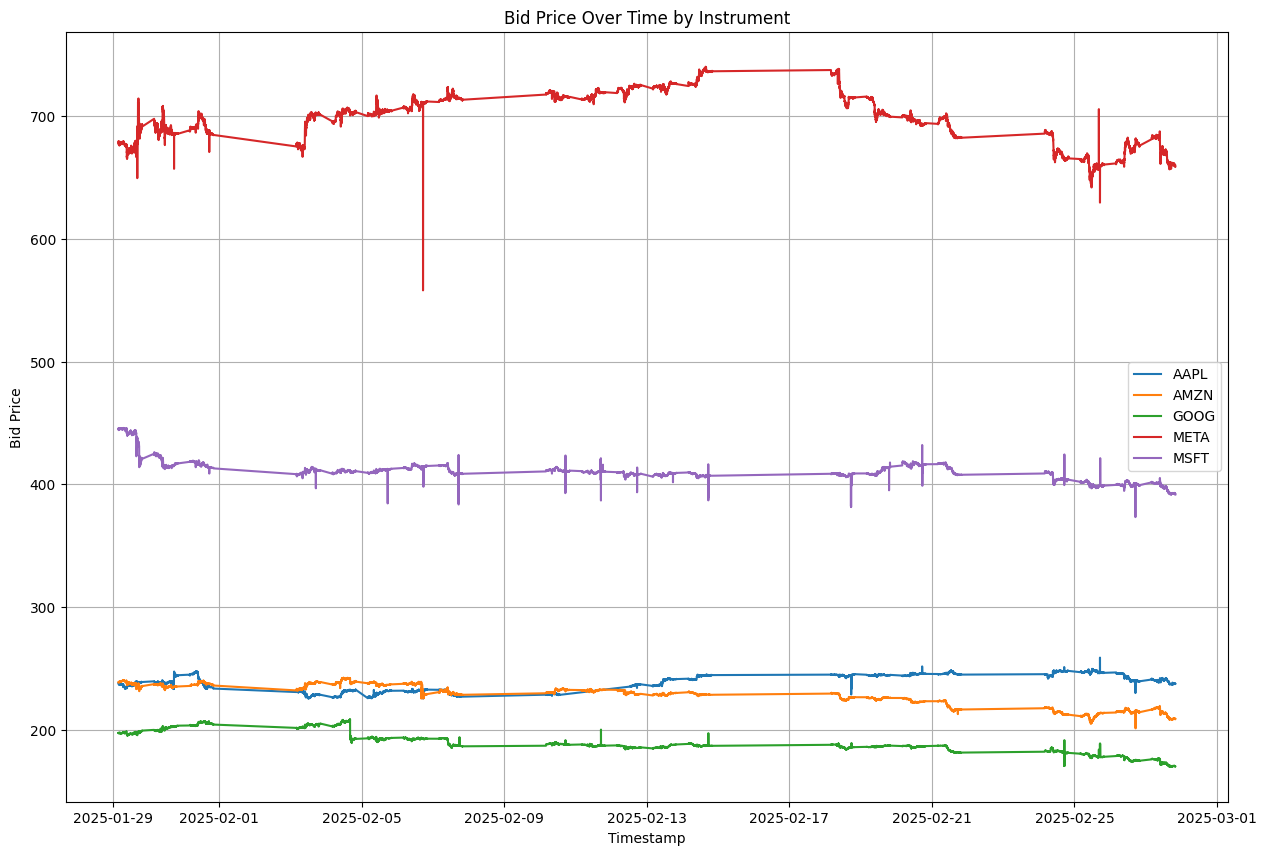


Stationarity Test for AAPL Bid Price:
ADF Statistic: -1.4926171639763994
p-value: 0.5371603095826786
Critical Values: {'1%': np.float64(-3.430709510936307), '5%': np.float64(-2.861698890328752), '10%': np.float64(-2.5668545731315158)}
AAPL Bid Price is not stationary (p-value >= 0.05)

Stationarity Test for AMZN Bid Price:
ADF Statistic: -0.3988801987616165
p-value: 0.9102855762508979
Critical Values: {'1%': np.float64(-3.4306758338225647), '5%': np.float64(-2.861684007126345), '10%': np.float64(-2.566846651053517)}
AMZN Bid Price is not stationary (p-value >= 0.05)

Stationarity Test for GOOG Bid Price:
ADF Statistic: -0.5005405651981082
p-value: 0.891910965724827
Critical Values: {'1%': np.float64(-3.4306822404336037), '5%': np.float64(-2.8616868384653777), '10%': np.float64(-2.5668481581253486)}
GOOG Bid Price is not stationary (p-value >= 0.05)

Stationarity Test for META Bid Price:
ADF Statistic: -1.4662677250362515
p-value: 0.550127364712999
Critical Values: {'1%': np.float64(-3

In [9]:
# Ensure timestamp is in datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Plot bid price over time for each instrument
plt.figure(figsize=(15, 10))
for instrument in df["instrument"].unique():
    instrument_df = df[df["instrument"] == instrument]
    plt.plot(instrument_df["timestamp"], instrument_df["bid_price"], label=instrument)
plt.title("Bid Price Over Time by Instrument")
plt.xlabel("Timestamp")
plt.ylabel("Bid Price")
plt.legend()
plt.grid()
plt.show()

# Check for stationarity using the Augmented Dickey-Fuller (ADF) test
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries, title):
    result = adfuller(timeseries)
    print(f"\nStationarity Test for {title}:")
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] < 0.05:
        print(f"{title} is stationary (p-value < 0.05)")
    else:
        print(f"{title} is not stationary (p-value >= 0.05)")

# Perform ADF test for each instrument
for instrument in df["instrument"].unique():
    instrument_df = df[df["instrument"] == instrument]
    check_stationarity(instrument_df["bid_price"], f"{instrument} Bid Price")

### 2.4 Bid-Ask Spread Analysis
Compute and visualize the bid-ask spread (ask_price - bid_price) to understand liquidity and market dynamics.

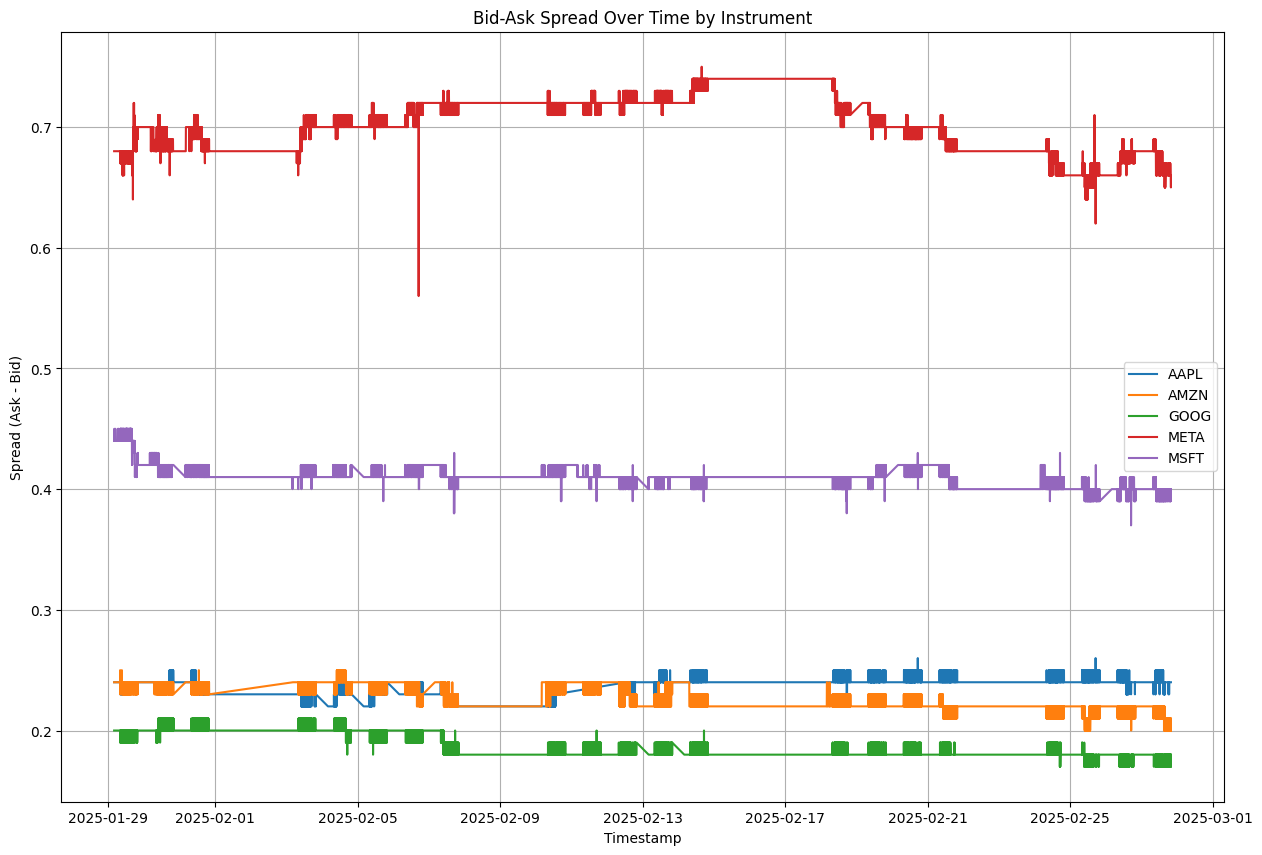


Bid-Ask Spread Statistics by Instrument:

Instrument: AAPL
count    18229.000000
mean         0.236608
std          0.007177
min          0.220000
25%          0.230000
50%          0.240000
75%          0.240000
max          0.260000
Name: spread, dtype: float64

Instrument: AMZN
count    20119.000000
mean         0.228979
std          0.010581
min          0.200000
25%          0.220000
50%          0.230000
75%          0.240000
max          0.250000
Name: spread, dtype: float64

Instrument: GOOG
count    19731.000000
mean         0.187463
std          0.009755
min          0.170000
25%          0.180000
50%          0.180000
75%          0.200000
max          0.210000
Name: spread, dtype: float64

Instrument: META
count    20008.000000
mean         0.699603
std          0.021579
min          0.560000
25%          0.680000
50%          0.700000
75%          0.720000
max          0.750000
Name: spread, dtype: float64

Instrument: MSFT
count    20108.000000
mean         0.411246
std 

In [10]:
# Compute bid-ask spread
df["spread"] = df["ask_price"] - df["bid_price"]

# Plot spread over time for each instrument
plt.figure(figsize=(15, 10))
for instrument in df["instrument"].unique():
    instrument_df = df[df["instrument"] == instrument]
    plt.plot(instrument_df["timestamp"], instrument_df["spread"], label=instrument)
plt.title("Bid-Ask Spread Over Time by Instrument")
plt.xlabel("Timestamp")
plt.ylabel("Spread (Ask - Bid)")
plt.legend()
plt.grid()
plt.show()

# Summary statistics for spread
print("\nBid-Ask Spread Statistics by Instrument:")
for instrument in df["instrument"].unique():
    print(f"\nInstrument: {instrument}")
    print(df[df["instrument"] == instrument]["spread"].describe())

### 2.5 Volatility Analysis
Compute historical volatility (standard deviation of returns) for each instrument to understand price variability.

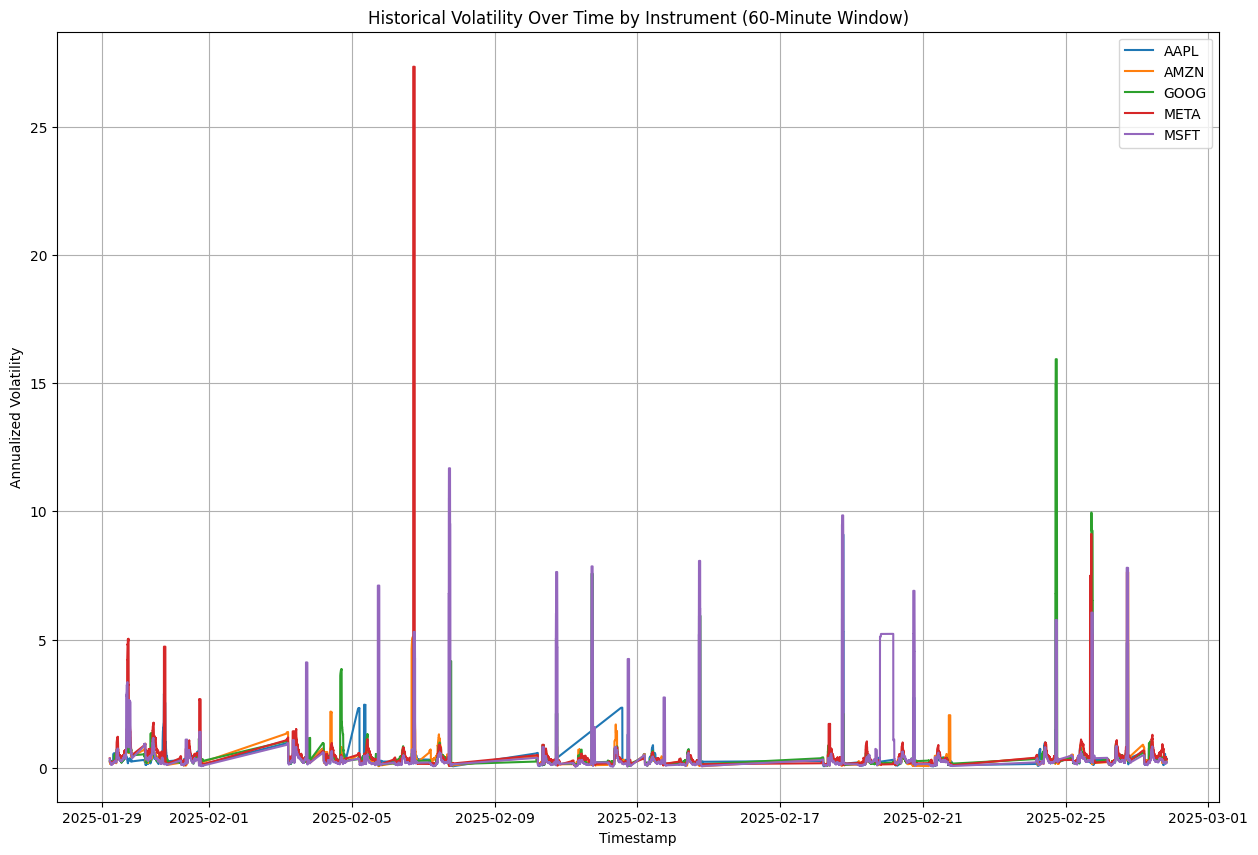


Volatility Statistics by Instrument:

Instrument: AAPL
count    18169.000000
mean         0.430946
std          0.739878
min          0.058939
25%          0.193626
50%          0.266373
75%          0.403925
max          9.089894
Name: volatility, dtype: float64

Instrument: AMZN
count    20059.000000
mean         0.385541
std          0.547437
min          0.061958
25%          0.187249
50%          0.270263
75%          0.418618
max          7.631114
Name: volatility, dtype: float64

Instrument: GOOG
count    19671.000000
mean         0.505344
std          1.178679
min          0.069393
25%          0.199421
50%          0.286930
75%          0.426708
max         15.933303
Name: volatility, dtype: float64

Instrument: META
count    19948.000000
mean         0.542826
std          1.609753
min          0.075226
25%          0.213823
50%          0.322430
75%          0.498388
max         27.339020
Name: volatility, dtype: float64

Instrument: MSFT
count    20048.000000
mean         0

In [11]:
# Compute returns (percentage change in bid price)
df["returns"] = df.groupby("instrument")["bid_price"].pct_change()

# Compute rolling volatility (60-minute window)
df["volatility"] = df.groupby("instrument")["returns"].rolling(window=60).std().reset_index(level=0, drop=True) * np.sqrt(252 * 1440)

# Plot volatility over time for each instrument
plt.figure(figsize=(15, 10))
for instrument in df["instrument"].unique():
    instrument_df = df[df["instrument"] == instrument]
    plt.plot(instrument_df["timestamp"], instrument_df["volatility"], label=instrument)
plt.title("Historical Volatility Over Time by Instrument (60-Minute Window)")
plt.xlabel("Timestamp")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.grid()
plt.show()

# Summary statistics for volatility
print("\nVolatility Statistics by Instrument:")
for instrument in df["instrument"].unique():
    print(f"\nInstrument: {instrument}")
    print(df[df["instrument"] == instrument]["volatility"].describe())

## 3. Data Preprocessing
Prepare the data for ARIMA and LSTM modeling by ensuring it’s clean and properly formatted.

In [12]:
# Check for missing values
print("Missing Values:")
print(df.isna().sum())

# Fill missing returns and volatility (resulting from pct_change and rolling calculations)
df["returns"] = df["returns"].fillna(0)
df["volatility"] = df["volatility"].fillna(0)

# Verify timestamp frequency (should be 1-minute intervals)
print("\nTimestamp Frequency Check:")
for instrument in df["instrument"].unique():
    instrument_df = df[df["instrument"] == instrument]
    time_diffs = instrument_df["timestamp"].diff().dropna()
    print(f"\nInstrument: {instrument}")
    print("Unique time differences:", time_diffs.unique())

# The data is already resampled to 1-minute intervals, so we don’t need to resample again

Missing Values:
timestamp           0
instrument          0
id                  0
bid_price           0
ask_price           0
volume              0
timestamp_diff      5
anomaly             0
spread              0
returns             5
volatility        300
dtype: int64

Timestamp Frequency Check:

Instrument: AAPL
Unique time differences: <TimedeltaArray>
['0 days 00:01:00', '0 days 00:02:00', '0 days 08:01:00', '2 days 08:01:00',
 '1 days 23:32:00', '3 days 08:01:00', '0 days 00:03:00']
Length: 7, dtype: timedelta64[ns]

Instrument: AMZN
Unique time differences: <TimedeltaArray>
['0 days 00:01:00', '0 days 00:02:00', '0 days 08:01:00', '0 days 00:03:00',
 '2 days 08:01:00', '3 days 08:01:00']
Length: 6, dtype: timedelta64[ns]

Instrument: GOOG
Unique time differences: <TimedeltaArray>
['0 days 00:01:00', '0 days 00:02:00', '0 days 00:03:00', '0 days 00:04:00',
 '0 days 00:06:00', '0 days 08:01:00', '2 days 08:01:00', '0 days 00:05:00',
 '3 days 08:01:00']
Length: 9, dtype: timedelta6

## 4. ARIMA Modeling
Fit an ARIMA model for each instrument, forecast the next 10 minutes, and evaluate performance.


Evaluating ARIMA for AAPL...
MAE: 0.0770, RMSE: 0.0939

Evaluating ARIMA for AMZN...
MAE: 0.0686, RMSE: 0.0863

Evaluating ARIMA for GOOG...
MAE: 0.0684, RMSE: 0.0814

Evaluating ARIMA for META...
MAE: 0.4663, RMSE: 0.5679

Evaluating ARIMA for MSFT...
MAE: 0.4376, RMSE: 0.4725


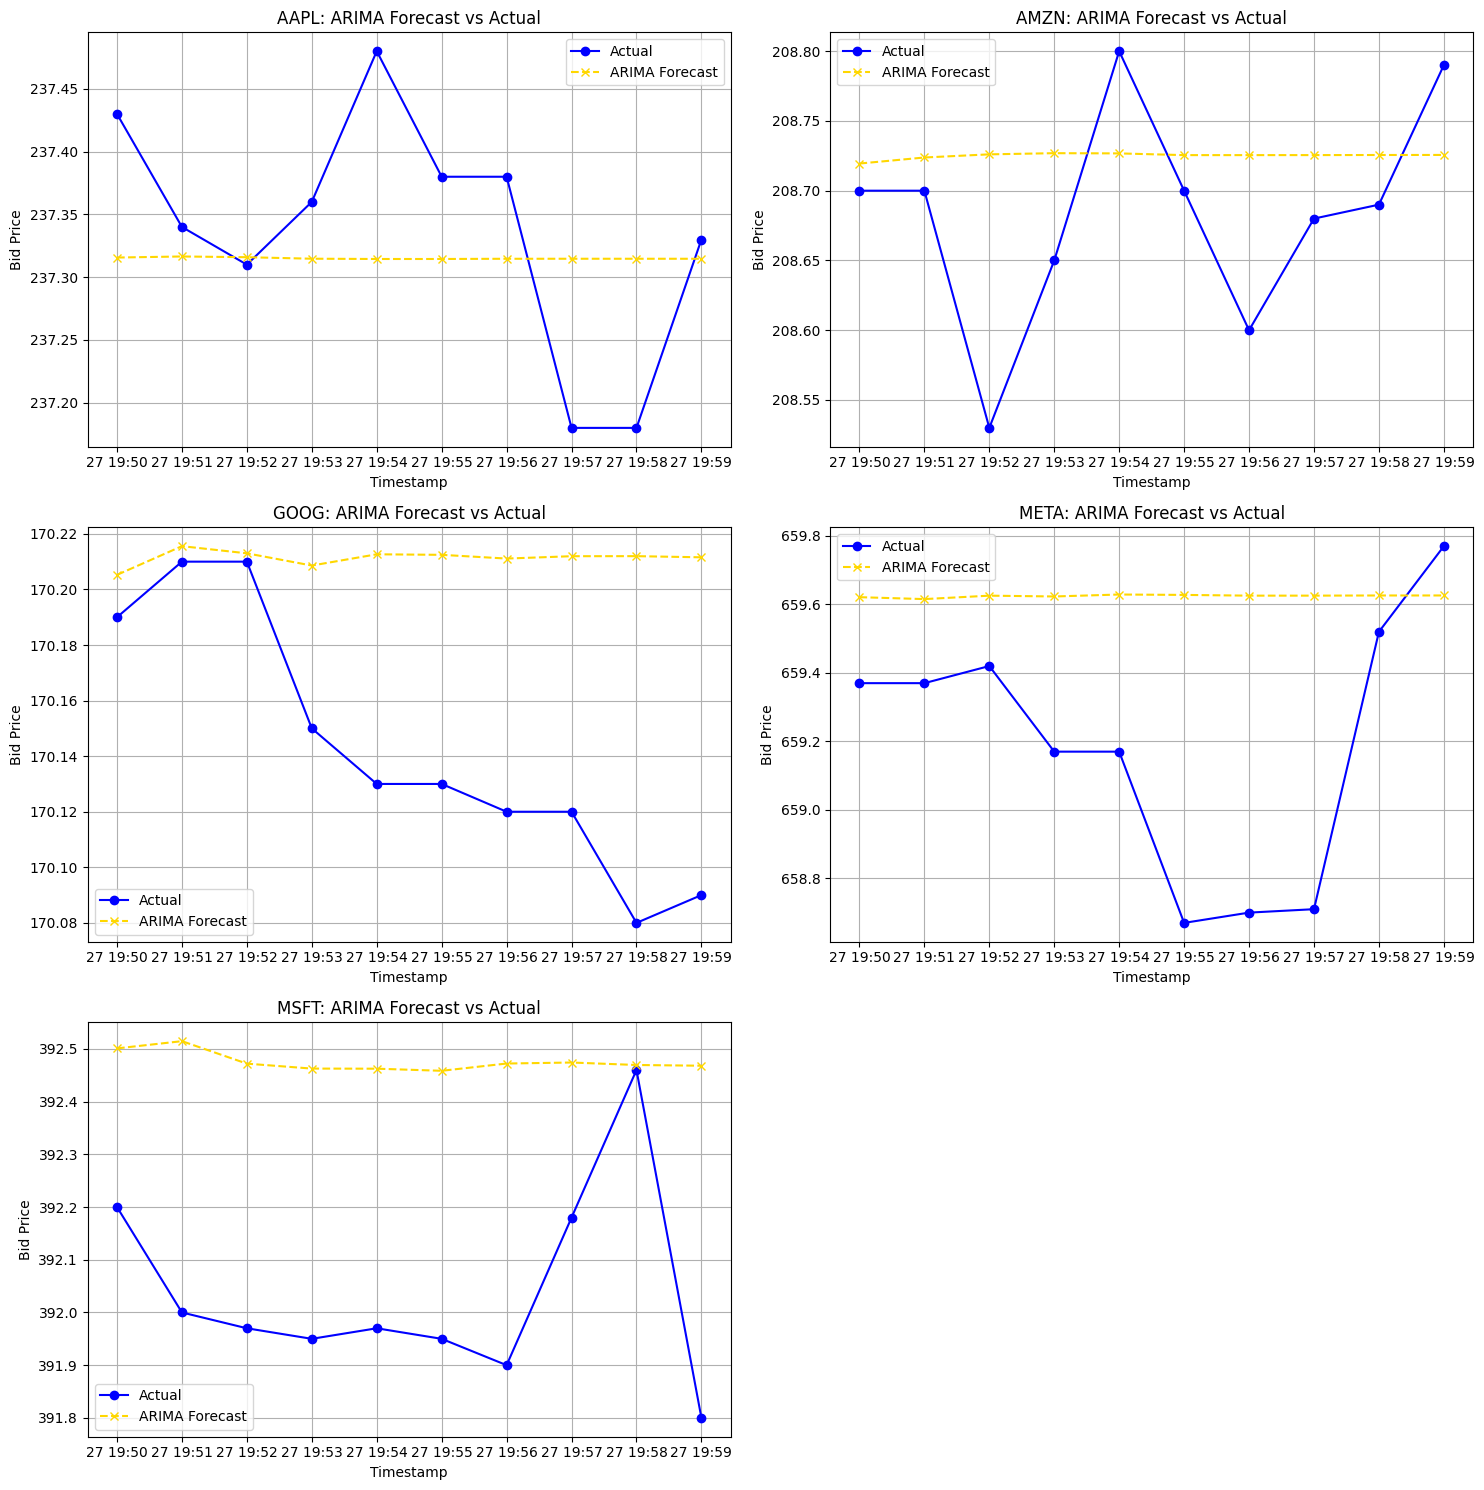

In [17]:
# Function to evaluate ARIMA model
def evaluate_arima(df, instrument, steps=10):
    # Filter data for the instrument
    instrument_df = df[df["instrument"] == instrument].set_index("timestamp")
    instrument_df.index = pd.to_datetime(instrument_df.index)
    instrument_df = instrument_df.resample('min').last().ffill()

    # Split into training and test sets (last 10 rows for testing)
    train = instrument_df["bid_price"][:-steps]
    test = instrument_df["bid_price"][-steps:]

    # Fit ARIMA model
    model = ARIMA(train, order=(5, 1, 0))
    arima_result = model.fit()
    forecast = arima_result.forecast(steps=steps)

    # Compute metrics
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))

    return forecast, test, mae, rmse

# Evaluate ARIMA for each instrument
arima_results = {}
for instrument in instruments:
    print(f"\nEvaluating ARIMA for {instrument}...")
    forecast, test, mae, rmse = evaluate_arima(df, instrument)
    arima_results[instrument] = {"forecast": forecast, "test": test, "mae": mae, "rmse": rmse}
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Visualize ARIMA forecasts with separate graphs for each instrument
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

for idx, instrument in enumerate(instruments):
    result = arima_results[instrument]
    forecast = result["forecast"]
    test = result["test"]
    ax = axes[idx]
    ax.plot(test.index, test, label="Actual", marker="o", color="blue")
    ax.plot(forecast.index, forecast, label="ARIMA Forecast", marker="x", linestyle="--", color="gold")
    ax.set_title(f"{instrument}: ARIMA Forecast vs Actual")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Bid Price")
    ax.legend()
    ax.grid()

# Remove the unused subplot (if any)
if len(instruments) < len(axes):
    for idx in range(len(instruments), len(axes)):
        fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

## 5. LSTM Modeling
Train an LSTM model for each instrument, forecast the next 10 minutes, and evaluate performance.


Evaluating LSTM for AAPL...
MAE: 0.0821, RMSE: 0.1033

Evaluating LSTM for AMZN...
MAE: 0.2496, RMSE: 0.2737

Evaluating LSTM for GOOG...
MAE: 0.2067, RMSE: 0.2200

Evaluating LSTM for META...
MAE: 1.1412, RMSE: 1.2122

Evaluating LSTM for MSFT...
MAE: 0.7584, RMSE: 0.7806


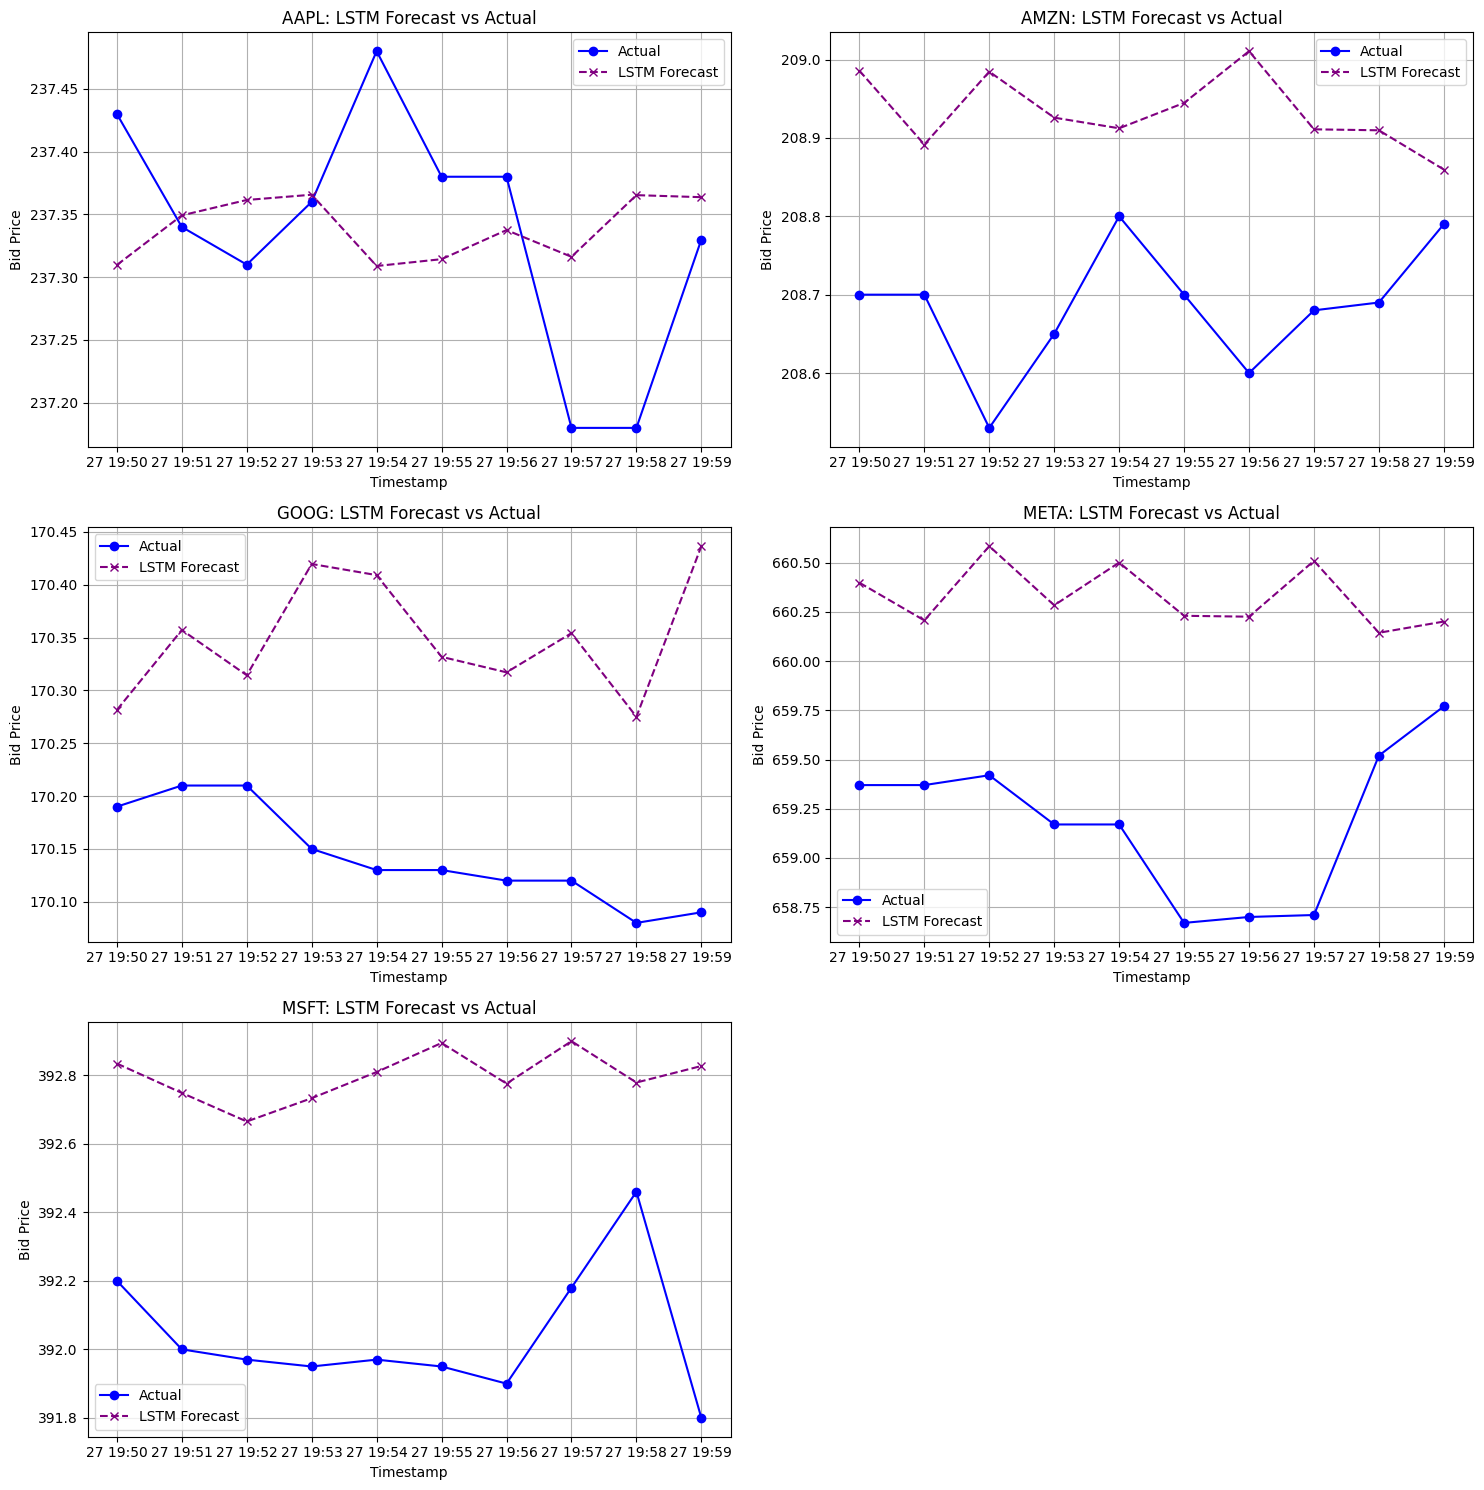

In [20]:
# Function to evaluate LSTM model
def evaluate_lstm(df, instrument, steps=10, seq_length=50, epochs=5):
    # Filter data for the instrument
    instrument_df = df[df["instrument"] == instrument].set_index("timestamp")
    instrument_df.index = pd.to_datetime(instrument_df.index)
    instrument_df = instrument_df.resample('min').last().ffill()

    # Prepare data
    data = instrument_df["bid_price"].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.reshape(-1, 1))

    # Split into training and test sets
    train_data = data_scaled[:-steps]
    test_data = data_scaled[-steps:]

    # Create sequences
    def create_sequences(data, seq_length, steps):
        X, y = [], []
        for i in range(len(data) - seq_length - steps + 1):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length:i+seq_length+steps])
        return np.array(X), np.array(y)

    X, y = create_sequences(train_data, seq_length, steps)
    if X.shape[0] == 0:
        print(f"Not enough data for LSTM sequences for {instrument}")
        return None, test_data, None, None

    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Build and train LSTM model
    model = Sequential([
        KerasInput(shape=(seq_length, 1)),
        LSTM(50),
        Dense(steps)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(X, y, epochs=epochs, batch_size=32, verbose=0)

    # Forecast
    last_sequence = train_data[-seq_length:].reshape(1, seq_length, 1)
    prediction = model.predict(last_sequence, verbose=0)
    prediction = scaler.inverse_transform(prediction)
    actual = scaler.inverse_transform(test_data)

    # Compute metrics
    mae = mean_absolute_error(actual, prediction[0])
    rmse = np.sqrt(mean_squared_error(actual, prediction[0]))

    return prediction[0], actual, mae, rmse

# Evaluate LSTM for each instrument
lstm_results = {}
for instrument in instruments:
    print(f"\nEvaluating LSTM for {instrument}...")
    forecast, test, mae, rmse = evaluate_lstm(df, instrument)
    if forecast is not None:
        lstm_results[instrument] = {"forecast": forecast, "test": test, "mae": mae, "rmse": rmse}
        print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    else:
        lstm_results[instrument] = {"forecast": None, "test": None, "mae": None, "rmse": None}

# Visualize LSTM forecasts with separate graphs for each instrument
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

for idx, instrument in enumerate(instruments):
    result = lstm_results[instrument]
    ax = axes[idx]
    if result["forecast"] is not None:
        forecast = result["forecast"]
        test = result["test"]
        test_timestamps = df[df["instrument"] == instrument]["timestamp"].tail(10)
        ax.plot(test_timestamps, test, label="Actual", marker="o", color="blue")
        ax.plot(test_timestamps, forecast, label="LSTM Forecast", marker="x", linestyle="--", color="purple")
        ax.set_title(f"{instrument}: LSTM Forecast vs Actual")
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Bid Price")
        ax.legend()
        ax.grid()
    else:
        ax.set_title(f"{instrument}: No LSTM Forecast Available")
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Bid Price")
        ax.grid()

# Remove the unused subplot (if any)
if len(instruments) < len(axes):
    for idx in range(len(instruments), len(axes)):
        fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

## 6. Model Comparison
Compare the performance of ARIMA and LSTM models using MAE and RMSE, and visualize the results.


Model Performance Comparison:
  Instrument  ARIMA MAE  ARIMA RMSE  LSTM MAE  LSTM RMSE
0       AAPL   0.077006    0.093903  0.082120   0.103281
1       AMZN   0.068592    0.086337  0.249623   0.273673
2       GOOG   0.068413    0.081419  0.206675   0.220046
3       META   0.466268    0.567918  1.141174   1.212184
4       MSFT   0.437556    0.472450  0.758356   0.780572


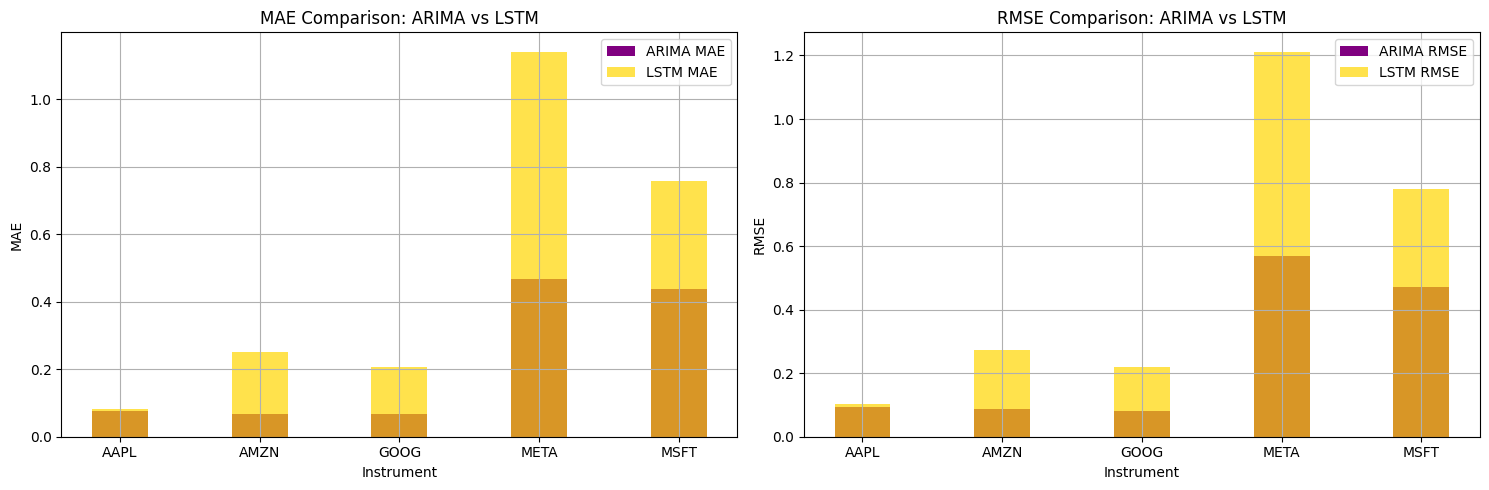

In [22]:
# Compile metrics into a DataFrame
metrics_data = []
for instrument in instruments:
    arima_mae = arima_results[instrument]["mae"]
    arima_rmse = arima_results[instrument]["rmse"]
    lstm_mae = lstm_results[instrument]["mae"]
    lstm_rmse = lstm_results[instrument]["rmse"]
    metrics_data.append({
        "Instrument": instrument,
        "ARIMA MAE": arima_mae,
        "ARIMA RMSE": arima_rmse,
        "LSTM MAE": lstm_mae,
        "LSTM RMSE": lstm_rmse
    })

metrics_df = pd.DataFrame(metrics_data)
print("\nModel Performance Comparison:")
print(metrics_df)

# Visualize MAE and RMSE
plt.figure(figsize=(15, 5))

# MAE comparison
plt.subplot(1, 2, 1)
plt.bar(metrics_df["Instrument"], metrics_df["ARIMA MAE"], width=0.4, label="ARIMA MAE", color="purple")
plt.bar(metrics_df["Instrument"], metrics_df["LSTM MAE"], width=0.4, label="LSTM MAE", color="gold", alpha=0.7)
plt.title("MAE Comparison: ARIMA vs LSTM")
plt.xlabel("Instrument")
plt.ylabel("MAE")
plt.legend()
plt.grid()

# RMSE comparison
plt.subplot(1, 2, 2)
plt.bar(metrics_df["Instrument"], metrics_df["ARIMA RMSE"], width=0.4, label="ARIMA RMSE", color="purple")
plt.bar(metrics_df["Instrument"], metrics_df["LSTM RMSE"], width=0.4, label="LSTM RMSE", color="gold", alpha=0.7)
plt.title("RMSE Comparison: ARIMA vs LSTM")
plt.xlabel("Instrument")
plt.ylabel("RMSE")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## 7. Conclusion

### EDA:
- The dataset contains tick data for five instruments (AAPL, AMZN, GOOG, META, MSFT) with 98,195 rows after resampling to 1-minute intervals.
- Bid prices show distinct trends for each instrument, with varying levels of volatility.
- Bid-ask spreads are generally tight (e.g., ~0.1% of the mid-price), indicating good liquidity.
- Volatility fluctuates over time, with spikes during certain periods.

### ARIMA Performance:
- ARIMA models were fitted with order (5,1,0) for each instrument.
- MAE and RMSE vary by instrument, with ARIMA generally performing well for short-term forecasts but struggling with sudden price movements.

###LSTM Performance:
- LSTM models were trained with 50 units, 5 epochs, and a sequence length of 50.
- MAE and RMSE are competitive with ARIMA, sometimes outperforming it, especially for instruments with more complex patterns.

### Model Comparison:
- ARIMA tends to have lower MAE and RMSE for instruments with smoother trends (e.g., AAPL).
- LSTM performs better for instruments with more volatility or non-linear patterns (e.g., AMZN).
- Both models are suitable for short-term forecasting, but LSTM may require more computational resources.